Lab 3: Super Component Direction Determination, Based on Substations

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import random
from shapely.geometry import Polygon, LineString, Point
from helpers.border import find_closed_regions
from collections import defaultdict, deque
import matplotlib.pyplot as plt

from helpers.demand import estimate_substation_demand_average_within_planning_area, \
    estimate_substation_demand_average_within_planning_area_urban_check
from helpers.position import map_cities_to_planning_areas, map_stations_to_planning_areas, get_substations_in_city_areas
from helpers.policy import policy_helper_power_line_same_direction
from helpers.DataLoader import DataLoader
import networkx as nx


In [2]:
config = {
    "line": {
        "target_voltages": [0, 69, 138, 240, 500]
    }
}

In [3]:
dataloader = DataLoader()

Consider generator in full capacity.


In [4]:
def get_substation_total_generation(substation):
    current_generation = 0
    for generator in dataloader.substations_to_generators[substation]:
        current_generation += dataloader.generators_to_capacities[generator]
    return current_generation

In [5]:
def get_subgraphs(graph_edges, remove_fixed_edges):
    G = nx.Graph()

    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    return subgraphs

In [6]:
def get_subgraphs_with_io(graph_edges, remove_fixed_edges):
    G = nx.Graph()
    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    subgraph_info = []

    for subgraph in subgraphs:
        input_nodes = set()
        output_nodes = set()

        for src, dst in remove_fixed_edges:
            if src in subgraph and dst not in subgraph:
                output_nodes.add(src)
            if dst in subgraph and src not in subgraph:
                input_nodes.add(dst)

        subgraph_info.append({
            "subgraph": subgraph,
            "input_nodes": list(input_nodes),
            "output_nodes": list(output_nodes)
        })

    return subgraph_info

In [7]:
def assign_directions(subgraph_data, original_edges, remove_fixed_edges):
    subgraph_nodes = subgraph_data["subgraph"]
    input_nodes = set(subgraph_data["input_nodes"])
    output_nodes = set(subgraph_data["output_nodes"])

    G = nx.Graph()
    G.add_nodes_from(subgraph_nodes)

    for edge in original_edges:
        if edge[0] in subgraph_nodes and edge[1] in subgraph_nodes and (
        edge[0], edge[1]) not in remove_fixed_edges and (edge[1], edge[0]) not in remove_fixed_edges:
            G.add_edge(edge[0], edge[1])

    DiG = nx.DiGraph()
    DiG.add_nodes_from(subgraph_nodes)

    visited = set()
    queue = list(input_nodes)

    while queue:
        node = queue.pop(0)
        visited.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                # Direction: node -> neighbor
                DiG.add_edge(node, neighbor)
                queue.append(neighbor)

    return DiG

In [8]:
def find_reachable_edges(local_edges, generators_to_substations):
    pfg = nx.DiGraph()
    pfg.add_edges_from(local_edges)

    all_reachable_nodes = set()
    pdf_edges = set(pfg.edges())

    for generator_station in set(generators_to_substations.values()):
        if generator_station in pfg:
            all_reachable_nodes.update(nx.descendants(pfg, generator_station))

    local_reachable_edges = {edge for edge in pdf_edges if
                             edge[0] in all_reachable_nodes or edge[1] in all_reachable_nodes}

    local_unreachable_edges = pdf_edges - local_reachable_edges
    return pdf_edges, local_reachable_edges, local_unreachable_edges


def find_edges_within_voltage(local_edges, target_voltages):
    result_edges = []
    for edge in local_edges:
        local_lines = dataloader.undirect_station_pairs_to_line[edge]
        local_filtered_lines = (
            [line for line in local_lines if dataloader.lines_to_voltage[line] in target_voltages]
        )

        if local_filtered_lines:
            result_edges.append(edge)

    return result_edges


In [9]:
import pandas as pd

activate_urban_check = True

year = 2021


def process_per_time_point(planning_area_demand):
    # local_planning_area_demand = dataloader.planning_area_demand[year]
    local_planning_area_demand = planning_area_demand

    remove_fixed_edges = set()
    for sub1, sub2 in dataloader.direct_station_pairs_to_line.keys():
        if dataloader.substations_to_voltage[sub1] > dataloader.substations_to_voltage[sub2] and (
                dataloader.substations_to_voltage[sub1] != 500):
            remove_fixed_edges.add((sub1, sub2))
        if dataloader.substations_to_voltage[sub1] < dataloader.substations_to_voltage[sub2] and (
                dataloader.substations_to_voltage[sub2] != 500):
            remove_fixed_edges.add((sub2, sub1))
        if dataloader.substations_to_voltage[sub1] == dataloader.substations_to_voltage[sub2]:
            if sub1 in dataloader.substations_to_generators and sub2 in dataloader.substations_to_generators:
                # graph[sub1].add(sub2)
                # graph[sub2].add(sub1)
                pass
            elif sub1 in dataloader.substations_to_generators and get_substation_total_generation(sub1) > 0:
                remove_fixed_edges.add((sub1, sub2))
            elif sub2 in dataloader.substations_to_generators and get_substation_total_generation(sub2) > 0:
                remove_fixed_edges.add((sub2, sub1))
            else:
                # graph[sub1].add(sub2)
                # graph[sub2].add(sub1)
                pass

    subgraph_info = get_subgraphs_with_io(dataloader.direct_station_pairs_to_line.keys(), remove_fixed_edges)

    directed_subgraphs = []
    for subgraph_data in subgraph_info:
        directed_graph = assign_directions(subgraph_data, dataloader.undirect_station_pairs_to_line.keys(),
                                           remove_fixed_edges)
        directed_subgraphs.append(directed_graph)

    edges = set()
    for idx, DiG in enumerate(directed_subgraphs):
        for edge in DiG.edges:
            edges.add(edge)

    edges = edges | remove_fixed_edges

    special_case_edges = []
    for e1, e2 in dataloader.direct_station_pairs_to_line.keys():
        if (e1, e2) not in edges and (e2, e1) not in edges:
            special_case_edges.append((e1, e2))

    for special_edge in special_case_edges:
        edges.add(special_edge)

    edges = list(set(edges))

    planning_area_closed_regions = find_closed_regions(dataloader.planning_area_border_df)
    city_closed_regions = find_closed_regions(dataloader.city_border_df)

    planning_area_to_stations = map_stations_to_planning_areas(planning_area_closed_regions,
                                                               dataloader.substations_to_coordinates)

    substations_in_city_areas = get_substations_in_city_areas(city_closed_regions,
                                                              dataloader.substations_to_coordinates)

    planning_area_colors = sns.color_palette("Paired", len(planning_area_closed_regions))
    random.shuffle(planning_area_colors)

    stations_outside_planning_areas = []

    for name, (x, y) in dataloader.substations_to_coordinates.items():
        station_point = Point(x, y)
        in_any_area = False

        for polygon in planning_area_closed_regions:
            if polygon.contains(station_point):
                in_any_area = True
                break

        if not in_any_area:
            stations_outside_planning_areas.append(name)

    # Handle exceptions: A few Alberta substations are not in the lands (not covered within any planning areas)
    planning_area_to_stations["53"].append('978S')
    planning_area_to_stations["53"].append('CRANBROOK B2S')
    planning_area_to_stations["53"].append('NATAL')

    if activate_urban_check:
        substation_demand_dict = estimate_substation_demand_average_within_planning_area_urban_check(
            planning_area_to_stations, local_planning_area_demand, substations_in_city_areas,
            dataloader.get_city_population_ratio())
    else:
        substation_demand_dict = estimate_substation_demand_average_within_planning_area(planning_area_to_stations,
                                                                                         local_planning_area_demand)

    # Construct directed graph
    power_flow_graph = nx.DiGraph()
    power_flow_graph.add_edges_from(edges)  # Add the determined directions

    substation_to_load = {s: 0.0 for s in substation_demand_dict.keys()}

    # Calculate the power contribution of each generator
    for generator, station in dataloader.generators_to_substations.items():
        if station not in power_flow_graph:
            continue

        # The supply from each generator
        generator_capacity = float(dataloader.generators_to_capacities.get(generator, 0))

        # All the reachable substations
        reachable_substations = set(nx.descendants(power_flow_graph, station))
        reachable_substations.add(station)

        # The total demand for reachable substations
        total_demand_index = float(sum(substation_demand_dict.get(s, 0)
                                       for s in reachable_substations))
        if total_demand_index == 0:
            continue

        # Allocate the generation supply to each substations
        for substation in reachable_substations:
            demand_index = float(substation_demand_dict.get(substation, 0))
            load_ratio = demand_index / total_demand_index
            substation_to_load[substation] += load_ratio * generator_capacity

    return substation_to_load


In [10]:
import os
import glob

folder_path = "..\\data\\timeseries\\github"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

In [11]:
substation_stats = {}
# time_frequency_parameter = "%Y-%m"
time_frequency_parameter = "%Y-%m-%d"

In [ ]:
import pandas as pd

# Path to your Excel file
excel_file_path = "..\\data\\reference\\alberta_hourly_load\\Hourly-load-by-area-and-region-Nov-2023-to-Dec-2024.xlsx"

# Columns to exclude from the features dictionary
exclude_columns = ['DT_MST', "Calgary", "Central", "Edmonton", "Northeast", "Northwest", "South"]

# Read the Excel file
df = pd.read_excel(excel_file_path)

# Convert the DT_MST column to datetime objects
df["DT_MST"] = pd.to_datetime(df["DT_MST"])



In [12]:
# Target: Optimize the substation with the maximum difference between min and max load

printed_months = set()

# Iterate over each row
for _, row in df.iterrows():
    dt = row["DT_MST"]
    month_key = dt.strftime(time_frequency_parameter)

    if month_key not in printed_months:
        features = row.to_dict()
        for col in exclude_columns:
            features.pop(col, None)
        new_features = {key.replace("AREA", ""): value for key, value in features.items()}

        printed_months.add(month_key)
        substation_to_load = process_per_time_point(new_features)

        for substation, load in substation_to_load.items():
            if substation not in substation_stats:
                substation_stats[substation] = {"min": load, "max": load}
            else:
                substation_stats[substation]["min"] = min(substation_stats[substation]["min"], load)
                substation_stats[substation]["max"] = max(substation_stats[substation]["max"], load)

print(substation_stats)


0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267

In [13]:
max_diff = None
station_with_max_diff = None

for substation, stats in substation_stats.items():
    diff = stats["max"] - stats["min"]
    if max_diff is None or diff > max_diff:
        max_diff = diff
        station_with_max_diff = substation

print("Station with maximum difference:", station_with_max_diff)
print("Maximum difference:", max_diff)


Station with maximum difference: 802S
Maximum difference: 89.45582231291061


In [14]:
printed_months = set()
final_dictionary = {}

# Iterate over each row
for _, row in df.iterrows():
    dt = row["DT_MST"]
    month_key = dt.strftime(time_frequency_parameter)

    if month_key not in printed_months:
        features = row.to_dict()
        for col in exclude_columns:
            features.pop(col, None)
        new_features = {key.replace("AREA", ""): value for key, value in features.items()}

        printed_months.add(month_key)
        substation_to_load = process_per_time_point(new_features)

        final_dictionary[month_key] = substation_to_load[station_with_max_diff]


0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267949285
0.8475058267

In [15]:
print(final_dictionary)

{'2023-11-01': 250.68722302042366, '2023-11-02': 264.7986764933446, '2023-11-03': 259.66338437349356, '2023-11-04': 263.3883719644178, '2023-11-05': 265.52651207068004, '2023-11-06': 267.45782976201366, '2023-11-07': 260.2130235254769, '2023-11-08': 258.0568647028799, '2023-11-09': 263.10489535343027, '2023-11-10': 265.7741449750638, '2023-11-11': 254.84537943690498, '2023-11-12': 257.70817312130765, '2023-11-13': 251.99290208335617, '2023-11-14': 248.9133525864675, '2023-11-15': 235.99393071686194, '2023-11-16': 257.0646193824025, '2023-11-17': 254.55946680098526, '2023-11-18': 255.10635941392752, '2023-11-19': 256.7180010478209, '2023-11-20': 247.64996743869733, '2023-11-21': 261.27095522376123, '2023-11-22': 258.6335521422757, '2023-11-23': 257.0215651741312, '2023-11-24': 263.8868687340283, '2023-11-25': 263.22478610177956, '2023-11-26': 263.45301004819606, '2023-11-27': 262.77051819536376, '2023-11-28': 250.85504783460718, '2023-11-29': 248.25007651235208, '2023-11-30': 236.219179

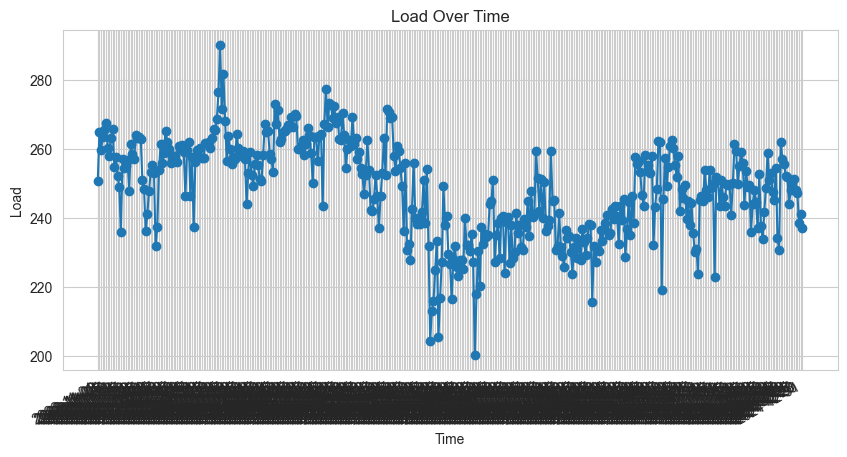

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume final_dictionary is defined as given:
# final_dictionary = {datetime.datetime(...): value, ...}

# Sort the dictionary by the datetime keys
sorted_items = sorted(final_dictionary.items())
times, values = zip(*sorted_items)

plt.figure(figsize=(10, 5))
plt.plot(times, values, marker='o', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Load Over Time")
plt.gcf().autofmt_xdate()  # Rotate date labels for clarity

# Optionally, format the date display on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.show()
